In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


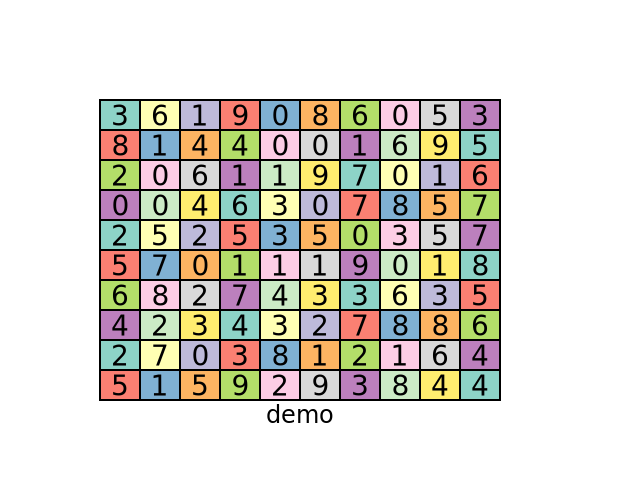

In [51]:
from canvas import Canvas
from colors import Set3
import random

sf = Canvas(640, 480)
N = 10
def mc(ji, e):
    return Set3[ji[0]*3+ji[1]]
a = [[random.randint(0,9) for j in range(N)] for i in range(N)]
bbox = sf.box_matrix(100,100,40,30, a, box_color=mc)
sf.text_align_to(bbox, 'demo', 24, align='bottom')
sf

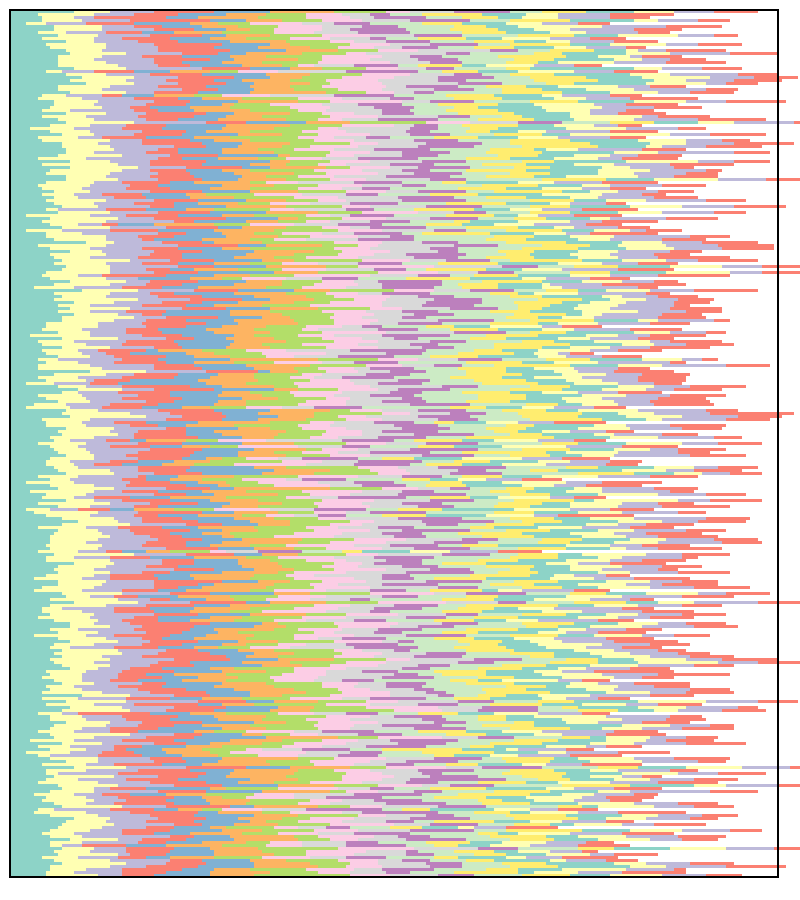

In [53]:
head_size = 64
page_size = 4096

class HT:
    def __init__(self, cap, item_size):
        subpage_size = (page_size - head_size) // 16
        slot_per_subpage = subpage_size // item_size
        self.slot_per_page = slot_per_subpage * 16
        self.item_size  = item_size
        self.npage = (cap + self.slot_per_page - 1) // self.slot_per_page
        self.pages = [0] * self.npage
        self.subpages = [[0] * 16 for i in range(self.npage)]
        self.nele = 0
    def put(self, v):
        subid = v & 0xfff
        pid = (v >> 12) % self.npage
        self.pages[pid] += 1
        self.subpages[pid][subid>>8] += 1
        self.nele+=1
    def reassign(self):
        pass
    def render(self, canvas, x, y, w, h):
        page_h = max(3, h // self.npage)
        slot_w = max(2, w // self.slot_per_page)
        for pid in range(self.npage):
            cx, cy = x, y + page_h * pid
            for subpid in range(16):
                cw = self.subpages[pid][subpid]*slot_w
                canvas.box(cx, cy, cw, page_h, Set3[subpid], 0)
                cx += cw
        canvas.box(x, y, slot_w * self.slot_per_page, page_h*self.npage,  '0000')

def show_ht(item_size, memory_size, seed=0, ratio=0.9):
    random.seed(seed)
    N = memory_size // item_size
    cap = int(N/ratio)
    ht = HT(cap, item_size)
    for i in range(N):
        v = random.randint(0, 0xffffffff)
        ht.put(v)
    sf = Canvas(800, 900)
    border = 10
    ht.render(sf, border, border, sf.width - 2*border, sf.height-2*border)
    return sf

show_ht(21, 1024*1024)